<h1><center>IPCV Project (Product Recognition)</center></h1>
<center>Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf.</center>
<br>

<h3><center>By: Gee Jun Hui Leonidas Yunani</center></h3>
<center>Email: leonidas.gee@studio.unibo.it</center>
<center>Academic Year: 2021 / 2022</center>

## Overall Task
Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).
3. Position in the image reference system of each instance (center of the bounding box that enclose them in pixel).

In [1]:
# Import the necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Define the load images function
def loadImg(models, scenes, colour=None):    
    model_lst = []
    scene_lst = []
    
    model_loc = 'dataset/models/'
    scene_loc = 'dataset/scenes/'
    
    for i in models:
        loc = model_loc + '{}.jpg'.format(i)
        if colour == 'gray':
            img = cv2.imread(loc, cv2.IMREAD_GRAYSCALE)
        elif colour == 'colour':
            img = cv2.imread(loc)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
        model_lst.append(img)
        
    for i in scenes:
        if colour == 'gray':
            img = cv2.imread(scene_loc + '{}.png'.format(i), 
                             cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = cv2.imread(scene_loc + '{}.jpg'.format(i), 
                                 cv2.IMREAD_GRAYSCALE)    
        elif colour == 'colour':
            img = cv2.imread(scene_loc + '{}.png'.format(i))
            if img is None:
                img = cv2.imread(scene_loc + '{}.jpg'.format(i))            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        scene_lst.append(img)
        
    return model_lst, scene_lst

## Step A - Multiple Product Detection:

- Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. The system should be able to correctly identify all the product in the shelves image.

In [3]:
# Load images for task 1 as grayscale
models, scenes = loadImg([0, 1, 11, 19, 24, 25, 26], ['e1', 'e2', 'e3', 'e4', 'e5'], 'gray')
print('Number of models: {}'.format(len(models)))
print('Number of scenes: {}'.format(len(scenes)))

Number of models: 7
Number of scenes: 5


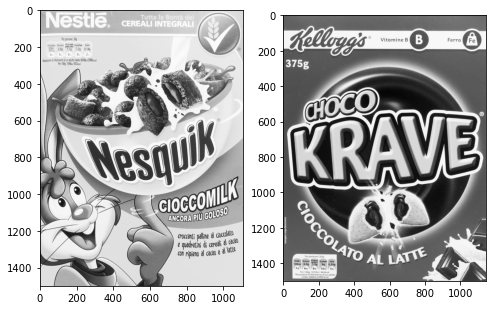

In [4]:
# Preview some sample product images
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(models[0], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(models[1], 'gray')
plt.show()

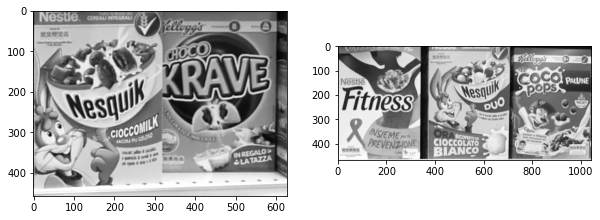

In [5]:
# Preview some sample scene images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(scenes[0], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(scenes[1], 'gray')
plt.show()

In [6]:
# Define the SIFT detector function
def siftDetect(image):
    sift = cv2.SIFT_create()
    kp = sift.detect(image)
    _, dsp = sift.compute(image, kp)
        
    return kp, dsp

In [7]:
# Compute the keypoints and descriptors for all models
kp_models = []
dsp_models = []

for model in models:
    kp_model, dsp_model = siftDetect(model)
    kp_models.append(kp_model)
    dsp_models.append(dsp_model)

In [8]:
# Define the function to visualise keypoints with their scale and orientation
def kpVisualise(images, keypoints):
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 2, 1)
    img_visual = cv2.drawKeypoints(images[0], keypoints[0], None, 
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print('Number of keypoints of image 1: {}'.format(len(keypoints[0])))
    plt.imshow(img_visual, 'gray')

    plt.subplot(1, 2, 2)
    img_visual = cv2.drawKeypoints(images[1], keypoints[1], None, 
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print('Number of keypoints of image 2: {}'.format(len(keypoints[1])))
    plt.imshow(img_visual, 'gray')
    
    plt.show()

Number of keypoints of image 1: 8081
Number of keypoints of image 2: 3192


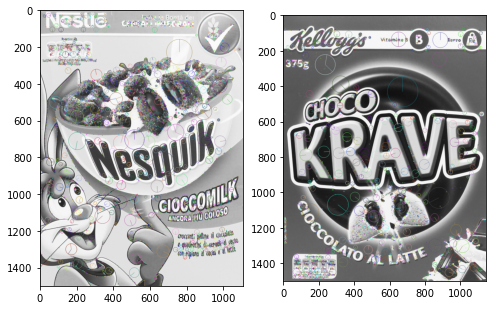

In [9]:
# Visualise sample keypoints of the models
kpVisualise(models, kp_models)

In [10]:
# Compute the keypoints and descriptors for all scenes
kp_scenes = []
dsp_scenes = []

for scene in scenes:
    kp_scene, dsp_scene = siftDetect(scene)
    kp_scenes.append(kp_scene)
    dsp_scenes.append(dsp_scene)

Number of keypoints of image 1: 2164
Number of keypoints of image 2: 2796


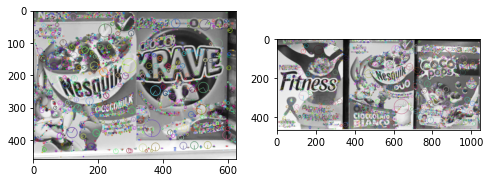

In [11]:
# Visualise sample keypoints of the scenes
kpVisualise(scenes, kp_scenes)

In [12]:
# Define the FLANN matching function
def flannMatch(dsp_model, dsp_scene):
    # Defining index for approximate kdtree algorithm
    flann_index_kdtree = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = flann_index_kdtree, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initialising the matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(dsp_model, dsp_scene, k=2)
    return matches

To filter the matches, Lowe proposed a distance ratio test to eliminate false matches. This ratio discriminates between ambiguous matches (distance ratio between the two nearest neighbors is close to one) and well discriminated matches. A match is considered to be good if the ratio is below a given threshold (typically 0.7).

In [13]:
# Define the Lowe's ratio filter function
def loweFilter(matches):
    good = []
    for n1, n2 in matches:
        if n1.distance < 0.7 * n2.distance:
            good.append(n1)
    return good

To find the position we have to compute, given the correspondences, a suitable transformation (i.e. homography) that brings points from the model reference system to the scene one. 

However, the bounding box obtained by transforming the corners of the model image to that of the scene with a homography computed using least square solution will lead to imprecise results. The RANSAC algorithm can thus be used to obtain a more accurate homography.

By setting a high MIN_MATCH_COUNT, false positive detections of models in the scenes can be reduced. However, some false positive detections may still remain such as the detection of model 0 in scene 1.

If statements are also used to ensure that only corners that generate a relatively rectangular bounding box are accepted thus further reducing false positive detections.

In [14]:
# Define the RANSAC function to compute the homography projection
def compPos(good, model, kp_model, kp_scene, n):
    # Check if enough matches have been found
    min_match_count = n
    
    if len(good) > min_match_count:
        # Building the corrspondences arrays of good matches
        src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()

        # Corners of the query image
        h, w = model.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts, M)
        
        # Ensure that the corners that are accepted generate a relatively rectangular shape
        # Only accept shapes whose corners are not clustered together
        if (dst[2][0][0] - dst[0][0][0]) > 50 and (dst[2][0][1] - dst[0][0][1]) > 50:
            # Only accept shapes whose corners create 4 relatively equal sides
            if abs(dst[2][0][0] - dst[3][0][0]) < 15 and abs(dst[2][0][1] - dst[1][0][1]) < 15:
                return matchesMask, dst

        return None, None
    else:
        return None, None

In [15]:
# Define the bounding box drawing function
def drawBox(model, scene, dst_lst, scene_only=False):
    product_lst = []
    # Drawing the bounding box
    scene_rgb = cv2.cvtColor(scene, cv2.COLOR_GRAY2RGB)
    for dst in dst_lst:
        drawn_img = cv2.polylines(scene_rgb, [np.int32(dst)], True, (0, 255, 0), 3)
        width = dst[2][0][0] - dst[0][0][0]
        height = dst[2][0][1] - dst[0][0][1]
        product_lst.append({'position': (dst[0][0][0] + width/2, dst[0][0][1] + height/2), 
                            'width': width, 
                            'height': height})
        
    # Preview model and drawn box
    if scene_only==True:
        plt.figure(figsize=(8, 8))
        plt.imshow(model, 'gray')
        plt.imshow(drawn_img)
    else:    
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(model, 'gray')
        plt.subplot(1, 2, 2)
        plt.imshow(drawn_img)
    plt.show()
    
    # Print coordinates, width and height of the object in the scene
    for i, product in enumerate(product_lst):
        print('Object {}: {}'.format(i+1, product))

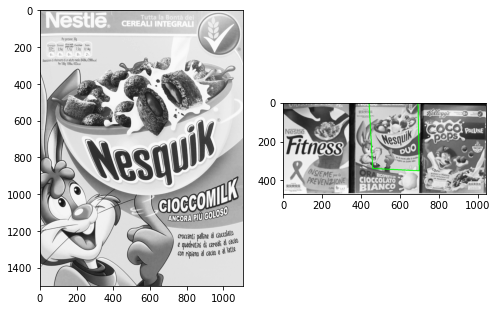

Object 1: {'position': (571.5936431884766, 172.74711990356445), 'width': 258.26108, 'height': 351.22766}


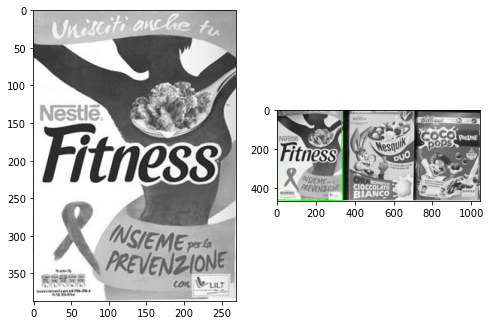

Object 1: {'position': (167.17521476745605, 218.62962341308594), 'width': 340.26868, 'height': 494.87042}


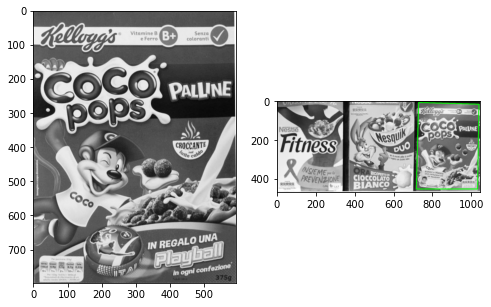

Object 1: {'position': (880.0350952148438, 230.04015684127808), 'width': 302.3944, 'height': 445.5425}


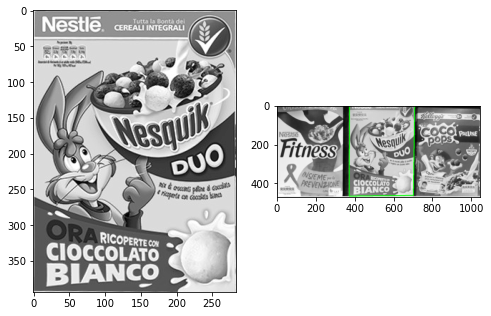

Object 1: {'position': (536.8036651611328, 216.7595272064209), 'width': 329.39474, 'height': 485.96356}


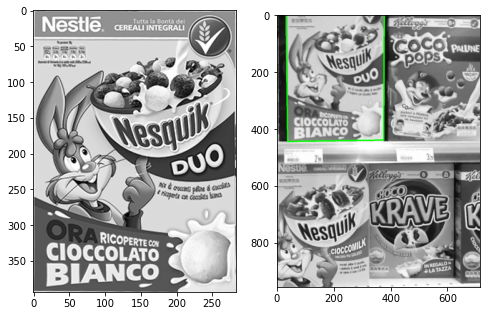

Object 1: {'position': (203.7864055633545, 193.27752685546875), 'width': 343.6936, 'height': 493.13733}


In [16]:
# Detect objects for all combinations of models and scenes
for i, model in enumerate(models):
    for j, scene in enumerate(scenes):
        matches = flannMatch(dsp_models[i], dsp_scenes[j])
        good = loweFilter(matches)
        _, dst = compPos(good, model, kp_models[i], kp_scenes[j], 200)
        
        if dst is not None:
            drawBox(model, scene, [dst])

The matches of the false positive detection can be visualised to find which keypoints contribute to the detection. It can be seen that most of the matches come from the "Nesquik" label that can also be found on a similar box in the scene.

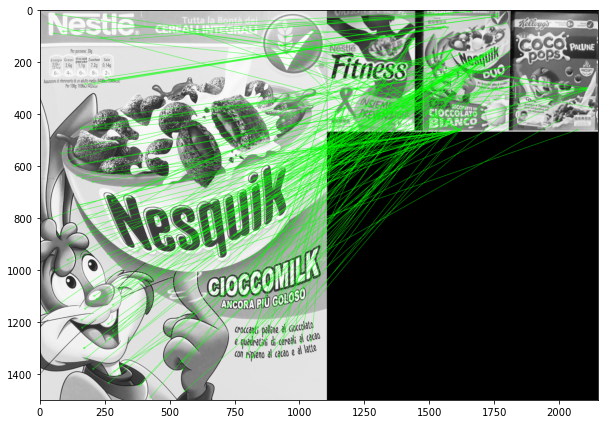

In [17]:
# Visualise the matches for the false positive detection
matches = flannMatch(dsp_models[0], dsp_scenes[1])
good = loweFilter(matches)
matchesMask, _ = compPos(good, models[0], kp_models[0], kp_scenes[1], 200)

draw_params = dict(matchColor = (0, 255, 0), # Draw matches in green color
                   singlePointColor = None, # Do not draw keypoints only matching lines
                   matchesMask = matchesMask, # Draw only inliers
                   flags = 2) # Do not draw keypoints only lines

img = cv2.drawMatches(models[0], kp_models[0], scenes[1], kp_scenes[1], 
                      good, None, **draw_params)
plt.figure(figsize=(10, 10))
plt.imshow(img, 'gray')
plt.show()

## Step B - Multiple Instance Detection:

- Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In addition to what achieved at step A, the system should now be able to detect multiple instance of the same product.

In [18]:
# Load images for task 2 as grayscale
models, scenes = loadImg([0, 1, 11, 19, 24, 25, 26], ['m1', 'm2', 'm3', 'm4', 'm5'], 'gray')
print('Number of models: {}'.format(len(models)))
print('Number of scenes: {}'.format(len(scenes)))

Number of models: 7
Number of scenes: 5


In [19]:
# Compute the keypoints and descriptors for all models
kp_models = []
dsp_models = []

for model in models:
    kp_model, dsp_model = siftDetect(model)
    kp_models.append(kp_model)
    dsp_models.append(dsp_model)

In [20]:
# Compute the keypoints and descriptors for all scenes
kp_scenes = []
dsp_scenes = []

for scene in scenes:
    kp_scene, dsp_scene = siftDetect(scene)
    kp_scenes.append(kp_scene)
    dsp_scenes.append(dsp_scene)

One method to detect more instances of an object in an image is to blacken an object area after detection and repeat the detection and area filling process until no more matches are found. The idea is to remove keypoints whose descriptors have been matched to allow for the matching of other keypoints whose descriptors can be matched with those from the object.

In [21]:
# Define the fill area drawing function
def fillArea(scene, dst):
    # Drawing the bounding box
    scene_copy = scene.copy()
    cv2.fillPoly(scene_copy, [np.int32(dst)], 0)
    return scene_copy

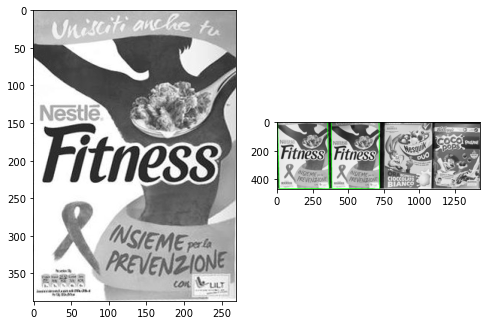

Object 1: {'position': (185.03730368614197, 212.61293029785156), 'width': 363.15262, 'height': 506.16342}
Object 2: {'position': (550.1962280273438, 218.69936752319336), 'width': 340.37244, 'height': 494.87747}


In [22]:
# Detect multiple instances of an object in an image
for i, model in enumerate(models):
    for j, scene in enumerate(scenes):
        dst_lst = []
        
        kp_scene = kp_scenes[j]
        dsp_scene = dsp_scenes[j]
        scene_c = scene.copy()
        
        while True:
            matches = flannMatch(dsp_models[i], dsp_scene)
            good = loweFilter(matches)
            _, dst = compPos(good, model, kp_models[i], kp_scene, 200)
            
            if dst is None:
                break
            
            dst_lst.append(dst)
            scene_c = fillArea(scene_c, dst)
            kp_scene, dsp_scene = siftDetect(scene_c)
        
        if len(dst_lst) >= 2:
            drawBox(model, scene, dst_lst)

## Step C - Whole Shelve Challenge:

- Test on scene image: {h1.png, h2.png, h3.png, h4.png, h5.png}
- Use product images: {from 0.jpg to 23.jpg}

Try to detect as much products as possible in this challenging scenario: more than 40 different product instances for each picture, distractor elements (e.g. price tags…) and low resolution image.

In [23]:
# Load images for task 1 as grayscale
models, scenes = loadImg(range(23), ['h1', 'h2', 'h3', 'h4', 'h5'], 'gray')
print('Number of models: {}'.format(len(models)))
print('Number of scenes: {}'.format(len(scenes)))

Number of models: 23
Number of scenes: 5


In [24]:
# Compute the keypoints and descriptors for all models
kp_models = []
dsp_models = []

for model in models:
    kp_model, dsp_model = siftDetect(model)
    kp_models.append(kp_model)
    dsp_models.append(dsp_model)

In [25]:
# Compute the keypoints and descriptors for all scenes
kp_scenes = []
dsp_scenes = []

for scene in scenes:
    kp_scene, dsp_scene = siftDetect(scene)
    kp_scenes.append(kp_scene)
    dsp_scenes.append(dsp_scene)

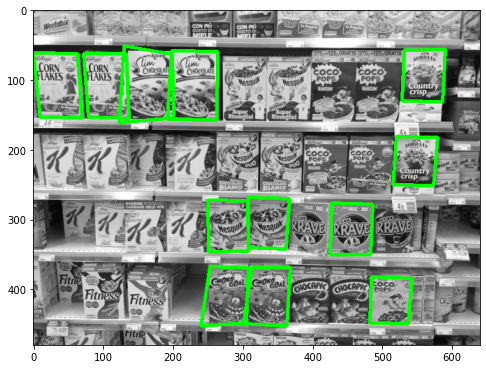

Object 1: {'position': (279.2167282104492, 309.287109375), 'width': 57.587967, 'height': 72.73059}
Object 2: {'position': (335.37120056152344, 305.96360778808594), 'width': 54.692352, 'height': 73.945526}
Object 3: {'position': (455.2681121826172, 313.2047424316406), 'width': 56.16806, 'height': 74.269226}
Object 4: {'position': (105.32799530029297, 108.98466873168945), 'width': 65.21419, 'height': 92.64961}
Object 5: {'position': (35.74889022111893, 108.34809494018555), 'width': 70.44681, 'height': 92.891884}
Object 6: {'position': (279.8087692260742, 408.1129150390625), 'width': 51.881546, 'height': 81.469055}
Object 7: {'position': (338.0909423828125, 411.1830291748047), 'width': 50.066284, 'height': 83.55936}
Object 8: {'position': (165.78133392333984, 103.06660461425781), 'width': 70.91295, 'height': 103.546814}
Object 9: {'position': (230.93839263916016, 107.89623641967773), 'width': 65.55528, 'height': 99.256966}
Object 10: {'position': (511.0101776123047, 416.05039978027344), '

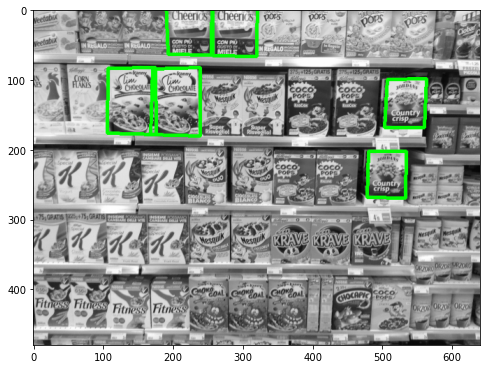

Object 1: {'position': (142.17998504638672, 130.96491622924805), 'width': 69.19475, 'height': 95.78556}
Object 2: {'position': (205.03484344482422, 132.71908950805664), 'width': 68.0215, 'height': 95.793846}
Object 3: {'position': (507.34190368652344, 236.2024917602539), 'width': 52.91971, 'height': 66.409836}
Object 4: {'position': (534.3231811523438, 133.84109497070312), 'width': 52.75708, 'height': 69.45828}
Object 5: {'position': (222.62456512451172, 14.924625396728516), 'width': 65.64641, 'height': 99.93946}
Object 6: {'position': (289.095947265625, 17.08001708984375), 'width': 62.916077, 'height': 99.45033}


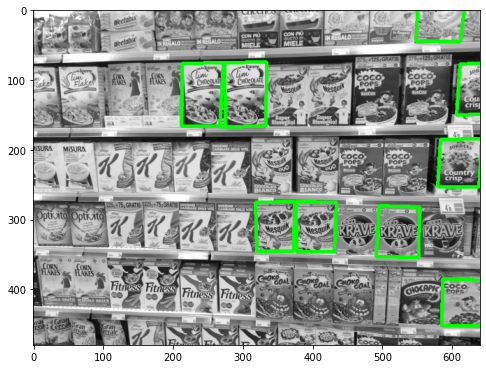

Object 1: {'position': (403.75440979003906, 310.7144317626953), 'width': 54.508453, 'height': 71.73917}
Object 2: {'position': (346.2117004394531, 310.21473693847656), 'width': 54.464966, 'height': 69.68338}
Object 3: {'position': (244.49874877929688, 121.5109977722168), 'width': 61.57843, 'height': 90.22755}
Object 4: {'position': (302.8294219970703, 120.99032211303711), 'width': 60.695404, 'height': 91.96986}
Object 5: {'position': (523.8145294189453, 317.6574401855469), 'width': 57.17697, 'height': 74.1142}
Object 6: {'position': (614.5252685546875, 419.21435546875), 'width': 56.109253, 'height': 66.69116}
Object 7: {'position': (582.3340148925781, -2.6444435119628906), 'width': 58.130554, 'height': 96.77852}
Object 8: {'position': (610.7904663085938, 219.76261138916016), 'width': 54.914673, 'height': 68.27321}
Object 9: {'position': (641.0214233398438, 112.9891357421875), 'width': 60.031006, 'height': 70.08356}


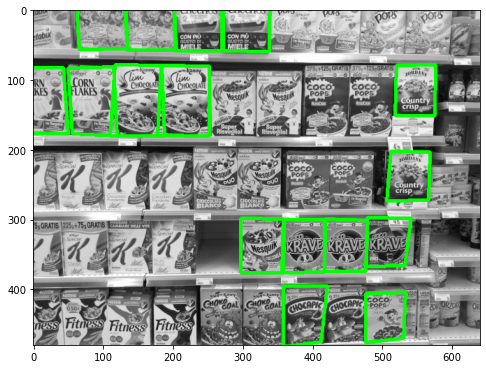

Object 1: {'position': (326.9591064453125, 337.54823303222656), 'width': 59.458252, 'height': 77.991486}
Object 2: {'position': (85.15275955200195, 131.88750076293945), 'width': 69.882935, 'height': 97.58184}
Object 3: {'position': (13.602191925048828, 130.17394638061523), 'width': 73.19609, 'height': 95.48676}
Object 4: {'position': (152.73973083496094, 129.50344848632812), 'width': 70.72159, 'height': 102.91763}
Object 5: {'position': (218.22945404052734, 129.90176391601562), 'width': 69.16005, 'height': 100.61267}
Object 6: {'position': (447.4409484863281, 337.16261291503906), 'width': 57.683044, 'height': 75.63327}
Object 7: {'position': (388.24708557128906, 337.9451141357422), 'width': 57.589874, 'height': 74.15762}
Object 8: {'position': (505.1455535888672, 331.82989501953125), 'width': 54.219025, 'height': 68.82538}
Object 9: {'position': (385.5946807861328, 435.18565368652344), 'width': 53.627228, 'height': 79.74783}
Object 10: {'position': (503.64768981933594, 438.400955200195

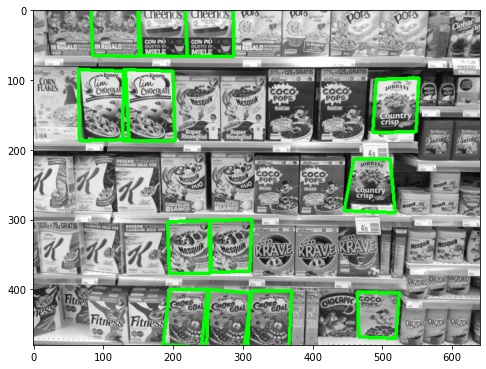

Object 1: {'position': (282.05970764160156, 337.5521240234375), 'width': 56.90982, 'height': 73.069336}
Object 2: {'position': (222.94781494140625, 340.06781005859375), 'width': 60.953003, 'height': 73.99054}
Object 3: {'position': (278.85717010498047, 442.1084899902344), 'width': 57.549515, 'height': 82.50006}
Object 4: {'position': (340.0512237548828, 443.8062286376953), 'width': 52.59433, 'height': 83.36728}
Object 5: {'position': (222.0027084350586, 442.1381378173828), 'width': 53.16469, 'height': 83.20877}
Object 6: {'position': (166.09850311279297, 136.49928665161133), 'width': 74.181076, 'height': 101.43871}
Object 7: {'position': (101.5981559753418, 135.34294509887695), 'width': 71.215126, 'height': 100.43258}
Object 8: {'position': (492.1381530761719, 437.3945770263672), 'width': 54.99591, 'height': 65.85831}
Object 9: {'position': (488.8158721923828, 251.7911376953125), 'width': 59.25107, 'height': 77.34625}
Object 10: {'position': (520.0710601806641, 137.10364151000977), 'wi

In [26]:
# Detect multiple instances of an object in an image
for i, scene in enumerate(scenes):
    dst_lst = []

    kp_scene = kp_scenes[i]
    dsp_scene = dsp_scenes[i]
    scene_c = scene.copy()
    
    for j, model in enumerate(models):
        while True:
            matches = flannMatch(dsp_models[j], dsp_scene)
            good = loweFilter(matches)
            _, dst = compPos(good, model, kp_models[j], kp_scene, 10)
            
            if dst is None:
                break
                
            dst_lst.append(dst)
            scene_c = fillArea(scene_c, dst)
            kp_scene, dsp_scene = siftDetect(scene_c)
        
    drawBox(model, scene, dst_lst, scene_only=True)

## Conclusion
The project utilises the concept of local invariant features and the matching of descriptors to find objects in an image. Given a single object in a relatively good image, the algorithm is able to locate and draw the bounding box around the object.

When the task requires the detection of more instances on an object in an image, one approach may be to blacken the detected object area and recompute the detection until no more matches are found.